In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/ch7"

archive.zip  chest_xray


In [5]:
!unzip "/content/drive/MyDrive/Colab Notebooks/ch7/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks/ch7/"

Archive:  /content/drive/MyDrive/Colab Notebooks/ch7/archive.zip
replace /content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!ls "/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray"

chest_xray  __MACOSX  test  train  val


In [7]:
!ls "/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/train"

NORMAL	PNEUMONIA


In [8]:
import os

print("Train")
print("NORMAL:", len(os.listdir("drive/MyDrive/Colab Notebooks/ch7/chest_xray/train/NORMAL")), end=', ')
print("PNEUMONIA:", len(os.listdir("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/train/PNEUMONIA")))
print()
print("Validation")
print("NORMAL:", len(os.listdir("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/val/NORMAL")), end=', ')
print("PNEUMONIA:", len(os.listdir("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/val/PNEUMONIA")))
print()
print("Test")
print("NORMAL:", len(os.listdir("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/test/NORMAL")), end=', ')
print("PNEUMONIA:", len(os.listdir("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/test/PNEUMONIA")))


Train
NORMAL: 1341, PNEUMONIA: 3875

Validation
NORMAL: 8, PNEUMONIA: 8

Test
NORMAL: 234, PNEUMONIA: 390


In [9]:
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/test/"
normal_dir=root+'NORMAL/'
peneumonia_dir=root+'PNEUMONIA/'

normal=list(map(lambda x:normal_dir+x,os.listdir(normal_dir)[:5]))
peneumonia=list(map(lambda x:peneumonia_dir+x,os.listdir(peneumonia_dir)[:5]))

samples=peneumonia+normal

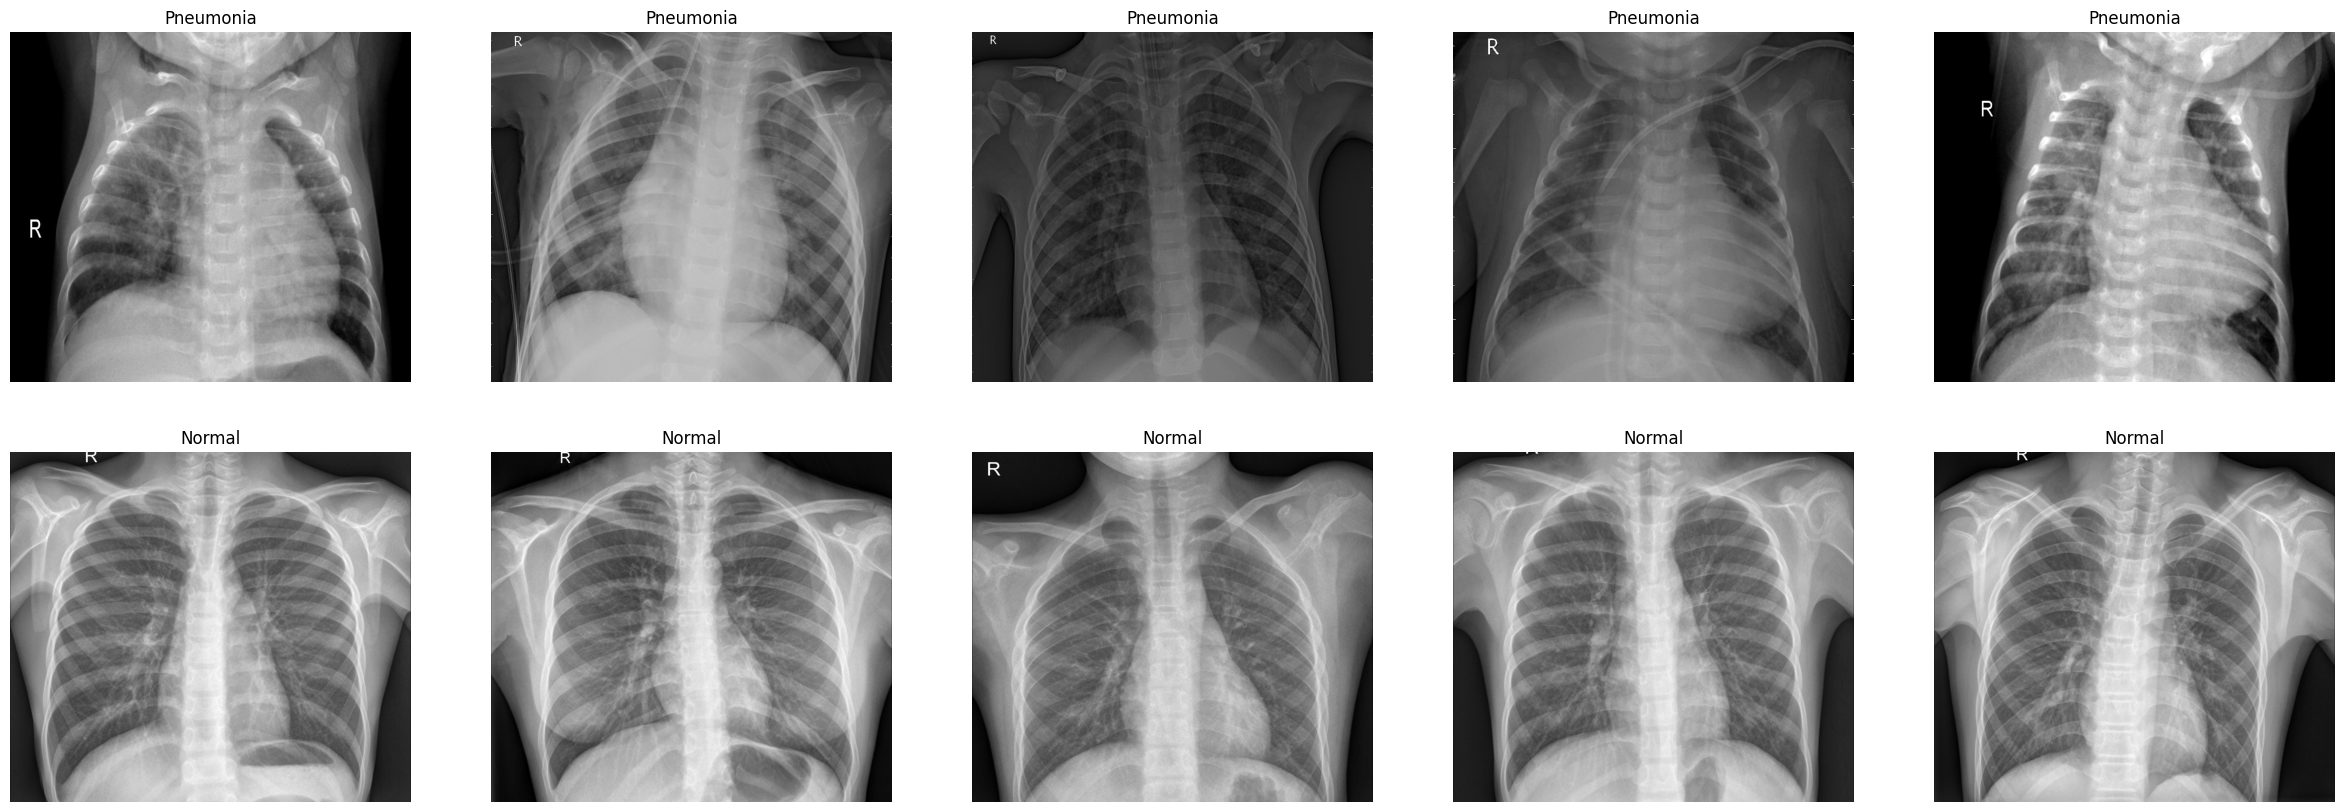

In [10]:
# show samples
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = Image.open(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [11]:
import os
from pathlib import Path
import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from torch import nn,optim
from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm

In [12]:
is_cuda=torch.cuda.is_available() #gpu 가 사용가능한지
device = torch.device('cuda' if is_cuda else 'cpu')
print(is_cuda, device)

False cpu


In [13]:
seed=100 # 시드는 100으로 설정
random.seed(seed) # 파이썬의 random 모듈은 난수생성
np.random.seed(seed)
torch.manual_seed(seed) #gpu 모델의 가중치 초기화와 같은 난수에 의존하는 연산을 일관되게 한다
if device=='cuda': #cuda를 사용하고 있는지 확인
  torch.cuda.manual_seed_all(seed) #사용 하고있다면 gpu에 대해 난수 생성기 초기화

### ImageFolder

In [14]:
!ls "/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/"

chest_xray  __MACOSX  test  train  val


In [15]:
!ls "/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/train"

NORMAL	PNEUMONIA


In [16]:
!ls "/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/train/NORMAL"

IM-0115-0001.jpeg	IM-0619-0001.jpeg		NORMAL2-IM-0832-0001.jpeg
IM-0117-0001.jpeg	IM-0620-0001-0001.jpeg		NORMAL2-IM-0833-0001.jpeg
IM-0119-0001.jpeg	IM-0620-0001-0002.jpeg		NORMAL2-IM-0834-0001.jpeg
IM-0122-0001.jpeg	IM-0620-0001.jpeg		NORMAL2-IM-0836-0001.jpeg
IM-0125-0001.jpeg	IM-0621-0001.jpeg		NORMAL2-IM-0837-0001.jpeg
IM-0127-0001.jpeg	IM-0622-0001-0001.jpeg		NORMAL2-IM-0838-0001.jpeg
IM-0128-0001.jpeg	IM-0622-0001-0002.jpeg		NORMAL2-IM-0839-0001.jpeg
IM-0129-0001.jpeg	IM-0622-0001.jpeg		NORMAL2-IM-0840-0001.jpeg
IM-0131-0001.jpeg	IM-0623-0001.jpeg		NORMAL2-IM-0841-0001.jpeg
IM-0133-0001.jpeg	IM-0624-0001-0002.jpeg		NORMAL2-IM-0842-0001.jpeg
IM-0135-0001.jpeg	IM-0624-0001.jpeg		NORMAL2-IM-0843-0001.jpeg
IM-0137-0001.jpeg	IM-0625-0001.jpeg		NORMAL2-IM-0845-0001.jpeg
IM-0140-0001.jpeg	IM-0626-0001-0001.jpeg		NORMAL2-IM-0846-0001.jpeg
IM-0141-0001.jpeg	IM-0626-0001-0002.jpeg		NORMAL2-IM-0847-0001.jpeg
IM-0143-0001.jpeg	IM-0627-0001.jpeg		NORMAL2-IM-0848-0001.jpeg
IM-0145-0001.jpeg	IM

In [17]:
from torch.utils.data.sampler import SubsetRandomSampler

#batch_size: 데이터를 배치로 처리할때 한 배치의 크기를 지정한다
#num_workers: 데이터 로딩시 사용할 프로세스수를 지정
def get_dataset(batch_size=128, val=0.1, num_workers=0,train_transform=[T.ToTensor()],test_transform=[T.ToTensor()]):
  data_dir=Path("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/")

  #transform
  train_transform=T.Compose(train_transform)
  test_transform=T.Compose(test_transform)

  #dataset
  trainset= datasets.ImageFolder(data_dir/'train',transform=train_transform)
  valset=datasets.ImageFolder(data_dir/'train',transform=test_transform)
  testset=datasets.ImageFolder(data_dir/'test',transform=test_transform)

  #split
  num_train=len(trainset)

  #indices 리스트는 데이터셋의 인덱스를 포함
  indices=list(range(num_train))

  #val * num_train은 전체 데이터 중 검증 데이터의 수를 계산
  split=int(np.floor(val*num_train))

  #train_idx는 split 인덱스 이후의 인덱스를 포함하여 훈련 세트용 인덱스를 생성
  #데이터 분할
  train_idx,valid_idx=  indices[split:],indices[:split]

  #SubsetRandomSampler는 주어진 인덱스 리스트(train_idx, valid_idx)를 사용하여 데이터셋의 특정 부분을 무작위로 샘플링하는 객체
  train_sampler=SubsetRandomSampler(train_idx)
  valid_sampler=SubsetRandomSampler(valid_idx)

  #dataloader
  train_loader=torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler ,
    num_workers=num_workers,pin_memory=True,
)
  val_loader=torch.utils.data.DataLoader(
    valset,batch_size=batch_size,sampler=valid_sampler,
    num_workers=num_workers, pin_memory=True
)

  test_loader=torch.utils.data.DataLoader(
    testset,batch_size=batch_size,num_workers=num_workers
)

  return trainset,valset,testset,train_loader,val_loader,test_loader

train_set,valset,testset, train_loader,val_loader , test_loader=get_dataset()

# **폐 X-레이 이미지 데이터셋을 처리하고, 훈련, 검증, 테스트 세트로 나누며 각 세트에 대한 데이터 로더를 설정하는 Python 함수 get_dataset을 정의**


def get_dataset(batch_size=128, val=0.1, num_workers=0,train_transform=[T.ToTensor()],test_transform=[T.ToTensor()]):
  data_dir=Path("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/")

train_transform:훈련데이터에 적용할 변환을 명시하는 리스트 기본적으로 이미지를 텐서로 변환하는 T.ToTensor()변환을 사용한다

T.ToToensor()는 torchvision.transforms 모듈에 있는 함수로, 이미지 데이터를 pytorch 텐서로 변환하는 역할을 한다. 이변환 과정은 이미지 작업에 있어서 필수적인 단계이다

SubsetRandomSampler는 주어진 인덱스 리스트(train_idx, valid_idx)를 사용하여 데이터셋의 특정 부분을 무작위로 샘플링하는 객체

# **ToToensor 주요기능**

1.   데이터 형식변환: 이미지를 PIL 형식이나 NumPy ndarray에서 PyTorch의 FloatTensor로 변환

2.   스케일링: 입력 이미지의 픽셀 값을 [0, 255] 범위에서 [0.0, 1.0] 범위로 정규화한다

3. 차원조정 : CHW 형식에맞춰 차원을 재조정한다



### **train_loade**r
는 trainset 을 사용한다 이는 훈련 데이터셋이며 , DataLoader 를 통해 배치크기로 데이터를 로드 한다

sampler=train_sampler 는 train_sampler는 train_sampler 를 사용하여 데이터를 무작위로 선택한다

num_worker는 데이터 로딩을 위해 사용할 작업자 수를 지정한다

### 검증 데이터와 테스트 데이터도 그대로 진행

# **DataLoader**

DataLoader는 PyTorch 라이브러리에서 데이터 로딩을 용이하게 해주는 매우 유용한 클래스이다. 이 클래스는 데이터셋을 효율적으로 핸들링하고, 미니 배치(mini-batch) 학습, 데이터 섞기(shuffling), 병렬 처리 등의 기능을 제공한다.

In [18]:
trainset, valset, testset, train_loader, val_loader, test_loader = get_dataset()

# 이제 trainset, valset, testset은 함수 외부에서 접근 가능한 변수
len(trainset), len(valset), len(testset)


(5216, 5216, 624)

In [19]:
len(train_loader.sampler), len(val_loader.sampler), len(testset)

(4695, 521, 624)

In [20]:
len(train_loader), len(val_loader), len(test_loader)

(37, 5, 5)

In [21]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [22]:
image, label = trainset[0]

print(image.shape)
print(label)

torch.Size([3, 1858, 2090])
0


# Model

Classification 모델을 사용해서 흉부엑스레이 분석

In [23]:
import torchvision.models as models

resnet18=models.resnet18()
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
from torchsummary import summary
summary(resnet18, (image.shape[0], image.shape[1], image.shape[2]))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 929, 1045]           9,408
       BatchNorm2d-2        [-1, 64, 929, 1045]             128
              ReLU-3        [-1, 64, 929, 1045]               0
         MaxPool2d-4         [-1, 64, 465, 523]               0
            Conv2d-5         [-1, 64, 465, 523]          36,864
       BatchNorm2d-6         [-1, 64, 465, 523]             128
              ReLU-7         [-1, 64, 465, 523]               0
            Conv2d-8         [-1, 64, 465, 523]          36,864
       BatchNorm2d-9         [-1, 64, 465, 523]             128
             ReLU-10         [-1, 64, 465, 523]               0
       BasicBlock-11         [-1, 64, 465, 523]               0
           Conv2d-12         [-1, 64, 465, 523]          36,864
      BatchNorm2d-13         [-1, 64, 465, 523]             128
             ReLU-14         [-1, 64, 4

In [25]:
resnet18.fc=nn.Linear(in_features=512,out_features=2,bias=True)
summary(resnet18,(image.shape[0],image.shape[1],image.shape[2]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 929, 1045]           9,408
       BatchNorm2d-2        [-1, 64, 929, 1045]             128
              ReLU-3        [-1, 64, 929, 1045]               0
         MaxPool2d-4         [-1, 64, 465, 523]               0
            Conv2d-5         [-1, 64, 465, 523]          36,864
       BatchNorm2d-6         [-1, 64, 465, 523]             128
              ReLU-7         [-1, 64, 465, 523]               0
            Conv2d-8         [-1, 64, 465, 523]          36,864
       BatchNorm2d-9         [-1, 64, 465, 523]             128
             ReLU-10         [-1, 64, 465, 523]               0
       BasicBlock-11         [-1, 64, 465, 523]               0
           Conv2d-12         [-1, 64, 465, 523]          36,864
      BatchNorm2d-13         [-1, 64, 465, 523]             128
             ReLU-14         [-1, 64, 4

In [26]:
def train(model,dataloader,criterion,optimizer,epoch,device):
  model.train()

  running_loss=0
  correct=0

  for i,(data,targets) in enumerate(tqdm(dataloader)):
    data,targets = data.to(device),targets.to(device)

    optimizer.zero_grad() #그라디언트를 0으로 설정하여, 새로운 미니배치에서의 그라디언트 계산에 이전 데이터의 영향을 받지 않도록 초기화
    outputs=model(data) #학습 데이터를 모델에 전달하여 예측 결과를 얻는다
    loss=criterion(outputs,targets) # loss계산
    loss.bachward() #gradient 계산
    optimizer.step() #모델의 파라미터를 업데이트

    running_loss+=loss.items() # 각 배치에서의 손실을 running_loss에 누적

    # 훈련데이터를 통해 모델의 파라미터 설정을 업데이트

    #Accuracy
    _,predicted=torch.max(outputs,1)
    correct+=predicted.eq(targets.view_as(predicted)).sum()

  #Accuracy 출력
  #전체 데이터셋에 대한 평균 손실과 정확도를 계산
  #현재 에폭에 대한 결과를 출력
  data_num=len(dataloader.sampler)
  acc=100.*correct/data_num
  print(f"[{epoch}] train loss: {running_loss / len(dataloader):.4f} train acc: {corrrect}/{data_num} ({acc:.2f}%)")

  return running_loss/len(dataloader),acc

### 모델 학습 설정
model.train()
data,targets=data.to(device),targets.to(device)

모델을 학습모드로 설정하고, 각 배치를 장치에 전달하여 처리

### 손실과 그라디언트 계산
loss=criterion(outputs,targets)

loss.backward()

각 배치에 대해 예측을 수행하고, 손실계산후 , 이를 바탕으로 그라디언트를 계산

### 가중치 업데이트
계산된 그라디언트를 사용하여 모델의 가중치를 업데이트

### 정확도 계산
예측된 결과와 실제 타겟을 비교하여 정확도를 계산

In [27]:
def validation(model,dataloader,criterion,epoch,device):
  #eval 모드
  model.eval()

  #검증통계
  correct=0
  running_loss=0

  with torch.no_grad():#gradinet 계산 안하기 : 메모리 사용량을 줄이고 연산속도를 빠르게 한다

    #dataloader 에서 배치를 하나씩 가져와, 각 데이터를 처리장치(device)로 이동시킨후 모델을 통해 예측을 수행한다
    for i ,(data,targets) in enumerate(tqdm(dataloader)): #dataloader에서 배치를 하나씩
      data,targets=data.to(device),targets.to(device) #data device로 이동
      outputs=model(data) #forward

      #예측된 결과 와 실제값을 비교하여 손실을 계산후 , 이를 running_loss 에 누적
      loss=criterion(outputs,targets) #loss계산
      running_loss+= loss.item()

      #Accuracy 계산
      #torchmax는 예측 결과중 가장 확률이 높은 클래스를 선택 . 이렇게 예측된 클래스가 실제 클래스와 일치하는지 확인후, 일치하는경우 correct를 증가시킴
      _,predicted=torch.max(outputs,1)
      correct+=predicted.eq(targets.view_as(predicted)).sum()

    #Accuracy 계산
    #데이터 총개수를 구하고 정확도를 계산하여 출력한다 평균손실과 정확도를 반환하여 검증과정의 결과를 요약
    data_num=len(dataloader.sampler)
    acc=100.*correct/data_num
    print(f'[{epoch}] valid loss:{running_loss/len(dataloader):.4f} valid acc:{correct}/{data_num} ({acc:.2f}%)\n')

    return running_loss/len(dataloader), acc


## torch.max 역할

예측결과중 가장 확률이 높은 클래스를 선택.

In [28]:
def test(model,dataloader,device):
  #eval 모드
  model.eval()

  #테스트 통계
  correct=0
  y_true=[]
  y_pred=[]

  with torch.no_grad():
    for data,targets in dataloader:
      data,targets=data.to(device),targets.to(device)

      outputs=model(data)

      #Accuracy 계산
      _,predicted= torch.max(outputs,1)
      correct+=predicted.eq(targets.view_as(predicted)).sum()

      y_true.append(targets)
      y_pred.append(outputs)

    #Accuracy 계산
    data_num=len(dataloader.dataset)
    print(f'Test Accuracy:{correct}/{data_num} ({100. *correct/data_num:.2f}%)')

    return 100.*correct/data_num , torch.cat(y_true), torch.cat(y_pred)

1. 평가모드설정 : 모델을 평가모드로 전환한다

2. 변수 초기화 : 정확한 예측의 수 와 실제 레이블 예측된 결과를 변수를 초기화

3. 데이터 처리 : 데이터 로더를 통해 데이터 배치와 레이블을 받고 해당 데이터를 처리장치로 이동시킨다

4. 예측실행 : 모델에 데이터를 입력하여 예측을 수행한다

5. 정확도 계산 : 예측된 결과와 실제 레이블을 비교하여 정확도를 계산

6. 결과저장 : 각 배치에서 실제 레이블과 예측 결과를 리스트에 추가

7. 최종결과 출력 및 변환

# 2.Albumentaions
딥러닝에서 학습속도는 매우 중요하다
학습속도가 빠를수록 더많은 실험을 할수있고 최적값을 찾는데 큰도움이된다

부족한 데이터셋을 보강하고 모델의 일반화 성능을 높이기 위해 우리는 Data augmentation 을 필수적으로 사용하고 있다.
Albumentation은 transform 을 더빠르게 하여 학습시간을 줄일수있고 더다양한 transform을 제공한다

기존의 Transform 이 어느정도 속도가 나오는지 살펴본다

In [30]:
# 이줄은 파이썬의 표준 라이브러리중 하나인 time 모듈을 임포트한다
import time
# 이 모듈은 이미지 전처리에 사용되는 다양한 변환 기능을 제공한다
import torchvision.transforms as T

#훈련데이터를 위한 변환 설정
train_transform = [

        # 이미지 크기를 조정
        T.Resize(size = (256,256)),
        #이미지를 랜덤하게 회전
        T.RandomRotation(degrees = (-20,+20)),
        #이미지의 중앙을 자른다
        T.CenterCrop(size=224),
        #이미지를 텐서로 변환
        T.ToTensor(),
        #텐서의 값을 정규화
        T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
]
test_transform = [
        T.Resize(size = (224,224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
]

#사용자 정의 함수 get_dataset 을 호출하여 데이터 셋과 데이터로더를 생성, 함수의 매개변수로는 배치크기 ,작업자수, 앞서 정읳한 변환설정이 포함
trainset, valset, testset, train_loader, val_loader, test_loader = get_dataset(
    128,
    num_workers=0,
    train_transform=train_transform,
    test_transform=test_transform)

#훈련 데이터 로더를 통한 반복
for i in tqdm(train_loader):
    pass


100%|██████████| 37/37 [06:40<00:00, 10.82s/it]


데이터 전처리와 로딩 절차를 설정하는 역할

데이터셋을 배치 단위로 반복 처리하면서, 각 반복마다 할 일을 정의할 수 있는 구조를 제공

In [31]:
!pip install -U opencv-python
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 28.2 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: scikit-image
    Found existing installation:

In [37]:
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler


class AlbumentationsDataset(ImageFolder):

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        #이미지 읽기
        image = cv2.imread(path)
        #이미지를 불러온후 bgr에서 rgb로 색상체계를 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #TRANSFORM
        #이미지에 적용할 변환이 있다면 변환수행
        if self.transform is not None:
            #설정된 변환을 이미지에 적용
            augmented = self.transform(image=image)
            image = augmented['image']
        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target

#데이터 path를 정의하고 데이터 로드해오기
#데이터 분할하기
def get_dataset(batch_size=128, val=0.1, num_workers=0, train_transform=T.Compose([T.ToTensor()]), test_transform=T.Compose([T.ToTensor()])):
    data_dir = Path("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/")

    # dataset
    trainset = AlbumentationsDataset(data_dir / 'train', transform=train_transform)
    valset = AlbumentationsDataset(data_dir / 'train', transform=test_transform)
    testset = AlbumentationsDataset(data_dir / 'test', transform=test_transform)

    # split
    num_train = len(trainset)
    indices = list(range(num_train))
    split = int(np.floor(val * num_train))

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # dataloader
    #데이터셋을 필요한 형식대로 로드
    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=True,
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=True,
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, num_workers=num_workers
    )

    return trainset, valset, testset, train_loader, val_loader, test_loader

In [38]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


#Albumentaions 라이브러리는 이미지 변환 옵션 제공
train_transform = A.Compose([
        A.Resize(256,256),
        A.Rotate(limit=(-20,+20)),
        A.CenterCrop(224, 224),
        A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ToTensorV2(),
])
test_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ToTensorV2(),
])


trainset, valset, testset, train_loader, val_loader, test_loader = get_dataset(
    128,
    num_workers=0,
    train_transform=train_transform,
    test_transform=test_transform)

for i in tqdm(train_loader):
    pass

100%|██████████| 37/37 [03:20<00:00,  5.41s/it]


이미지 변환옵션을 각 데이터셋에 적용

In [39]:
test_transform = A.Compose([
        A.Resize(256,256),
        A.OneOf([
            A.HorizontalFlip(p=1),
            A.RandomRotate90(p=1),
            A.VerticalFlip(p=1)
        ], p=1),
        A.CenterCrop(224, 224),
        A.OneOf([
            A.MotionBlur(p=1),
            A.OpticalDistortion(p=1),
            A.GaussNoise(p=1)
        ], p=1),
        ToTensorV2(),
])

data_dir = Path("/content/drive/MyDrive/Colab Notebooks/ch7/chest_xray/")
testset = AlbumentationsDataset(data_dir / 'test', transform=test_transform)

albumentations 의 고급설정을 통해 , testset 변환

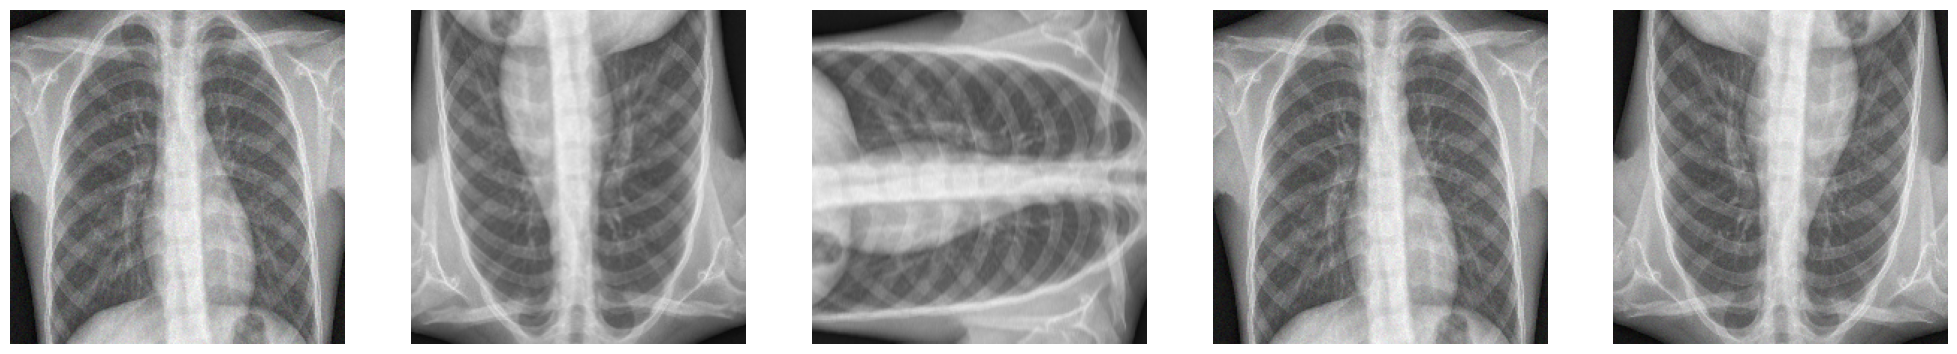

In [40]:
num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(T.ToPILImage()(testset[0][0]))
  ax[i].axis('off')